In [1]:
# 各種好用套件
import os, random, sys, keras, math
import numpy as np

# 大畫家
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

# k~k~k~~~~Keras core sturcture
from keras.models import Sequential, Model
from keras.layers import Activation, Input, Dense, Lambda, Dropout, concatenate, Flatten, Reshape
from keras.initializers import Ones

# some
from keras import initializers
from keras.constraints import max_norm, non_neg, unit_norm
from keras import backend as K
from keras import metrics

# used for RGB to Lab transformation
from skimage import color
color.colorconv.lab_ref_white = np.array([95.047, 100.0, 108.883])

# MNIST:
#     Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
from keras.datasets import mnist
# CIFAR10: 
#     Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.
from keras.datasets import cifar10

Using Theano backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train/255
x_test = x_test/255

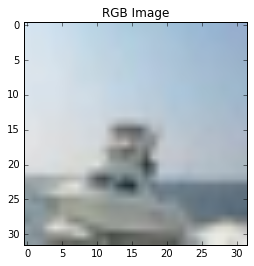

In [4]:
imgNumber = 100

rgb_data = x_train[imgNumber]
plt.imshow(rgb_data)
plt.title('RGB Image')

In [5]:
# x_train.shape: (50000, 32, 32, 3)
x_train_R = x_train[:,:,:,0]
x_train_G = x_train[:,:,:,1]
x_train_B = x_train[:,:,:,2]

In [6]:
x_R_img = Input(shape=(32, 32,), name='R_part')
x_R = Flatten()(x_R_img)

x_G_img = Input(shape=(32, 32,), name='G_part')
x_G = Flatten()(x_G_img)

x_B_img = Input(shape=(32, 32,), name='B_part')
x_B = Flatten()(x_B_img)

enc_R = Dense(100, activation='relu')(x_R)
h_R = Dense(2, activation='relu')(enc_R)
dec_R = Dense(100, activation='relu')(h_R)
dec_R_img = Dense(32*32, activation='sigmoid')(dec_R)
x_G_reconstructed = Reshape((32, 32))(dec_R_img)

enc_G = Dense(100, activation='relu')(x_G)
h_G = Dense(2, activation='relu')(enc_G)
dec_G = Dense(100, activation='relu')(h_G)
dec_G_img = Dense(32*32, activation='sigmoid')(dec_G)
x_B_reconstructed = Reshape((32, 32))(dec_G_img)

enc_B = Dense(100, activation='relu')(x_B)
h_B = Dense(2, activation='relu')(enc_B)
dec_B = Dense(100, activation='relu')(h_B)
dec_B_img = Dense(32*32, activation='sigmoid')(dec_B)
x_R_reconstructed = Reshape((32, 32))(dec_B_img)

model = Model([x_R_img, x_G_img, x_B_img], [x_G_reconstructed, x_B_reconstructed, x_R_reconstructed])

In [7]:
def my_loss(y_true, y_pred):
    error_G = x_G_img - x_G_reconstructed
    error_B = x_B_img - x_B_reconstructed
    error_R = x_R_img - x_R_reconstructed
    
    mse_G = K.mean(K.square(error_G))
    mse_B = K.mean(K.square(error_B))
    mse_R = K.mean(K.square(error_R))
    return mse_R + mse_G + mse_B

In [8]:
#model.compile(loss='mse', optimizer='rmsprop')
model.compile(loss=my_loss, optimizer='rmsprop')

In [9]:
model.fit([x_train_R, x_train_G, x_train_B], [x_train_G, x_train_B, x_train_R], verbose=2,
          epochs=10, batch_size=500)

Epoch 1/10
11s - loss: 0.5494 - reshape_1_loss: 0.1831 - reshape_2_loss: 0.1831 - reshape_3_loss: 0.1831
Epoch 2/10
11s - loss: 0.5272 - reshape_1_loss: 0.1757 - reshape_2_loss: 0.1757 - reshape_3_loss: 0.1757
Epoch 3/10
11s - loss: 0.5182 - reshape_1_loss: 0.1727 - reshape_2_loss: 0.1727 - reshape_3_loss: 0.1727
Epoch 4/10
11s - loss: 0.5155 - reshape_1_loss: 0.1718 - reshape_2_loss: 0.1718 - reshape_3_loss: 0.1718
Epoch 5/10
11s - loss: 0.5148 - reshape_1_loss: 0.1716 - reshape_2_loss: 0.1716 - reshape_3_loss: 0.1716
Epoch 6/10
12s - loss: 0.5140 - reshape_1_loss: 0.1713 - reshape_2_loss: 0.1713 - reshape_3_loss: 0.1713
Epoch 7/10
14s - loss: 0.5135 - reshape_1_loss: 0.1712 - reshape_2_loss: 0.1712 - reshape_3_loss: 0.1712
Epoch 8/10
14s - loss: 0.5132 - reshape_1_loss: 0.1711 - reshape_2_loss: 0.1711 - reshape_3_loss: 0.1711
Epoch 9/10
14s - loss: 0.5129 - reshape_1_loss: 0.1710 - reshape_2_loss: 0.1710 - reshape_3_loss: 0.1710
Epoch 10/10
14s - loss: 0.5127 - reshape_1_loss: 0.1709

In [10]:
imgNumber = 2

test = x_train[imgNumber : imgNumber+1, :, :, :]
test_R = test[:,:,:, 0]
test_G = test[:,:,:, 1]
test_B = test[:,:,:, 2]


In [11]:
G, B, R = model.predict([test_R, test_G, test_B])

In [12]:
G.shape

(1, 32, 32)

(-0.5, 31.5, 31.5, -0.5)

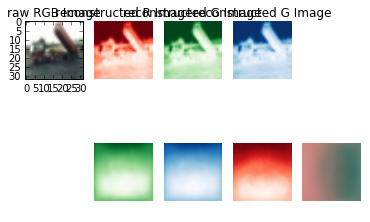

In [13]:
# raw image
plt.subplot(251)
plt.imshow(test[0])
plt.title('raw RGB Image')

plt.subplot(252)
plt.imshow(test_R[0], cmap='Reds')
plt.title('reconstructed R Image')
plt.axis('off')

plt.subplot(253)
plt.imshow(test_G[0], cmap='Greens')
plt.title('reconstructed G Image')
plt.axis('off')

plt.subplot(254)
plt.imshow(test_B[0], cmap='Blues')
plt.title('reconstructed G Image')
plt.axis('off')

# reconstructed image
plt.subplot(259)
plt.imshow(R[0], cmap='Reds')
#plt.title('reconstructed R Image')
plt.axis('off')

plt.subplot(257)
plt.imshow(G[0], cmap='Greens')
#plt.title('reconstructed G Image')
plt.axis('off')

plt.subplot(258)
plt.imshow(B[0], cmap='Blues')
#plt.title('reconstructed G Image')
plt.axis('off')

plt.subplot(2,5,10)
plt.imshow(np.array([R[0], G[0], B[0]]).T)
#plt.title('reconstructed Image')
plt.axis('off')


In [14]:
np.array([R[0], G[0], B[0]]).shape

(3, 32, 32)